<a href="https://colab.research.google.com/github/DDursun/Violence-Detection/blob/main/Feature_extraction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Loading the data

In [2]:
# Imports for data loading and feature engineering

import random
import os
import numpy as np
import pandas as pd

import cv2
import matplotlib.pyplot as plt
import imgaug.augmenters as iaa

from google.colab import drive


In [3]:
drive.mount('/content/drive')

Mounted at /content/drive


Defining constants

In [4]:
DATASET =    "/content/drive/My Drive/extracted_files/Real Life Violence Dataset"
CLASSES = ["NonViolence","Violence"]
NonViolent = f"{DATASET}/NonViolence"
Violent =    f"{DATASET}/Violence/"

# Retrieving the list of all the video files present in both class directory
NonViolence_files_names_list = os.listdir(NonViolent)
Violence_files_names_list = os.listdir(Violent)

# Height and width to which each video frame will be resized in our dataset.
HEIGHT, WIDTH = 100, 100

# Number of frames of a video that will be fed to the model as one sequence.
nframes = 15
nclass = len(CLASSES)


## Example visuals from dataset

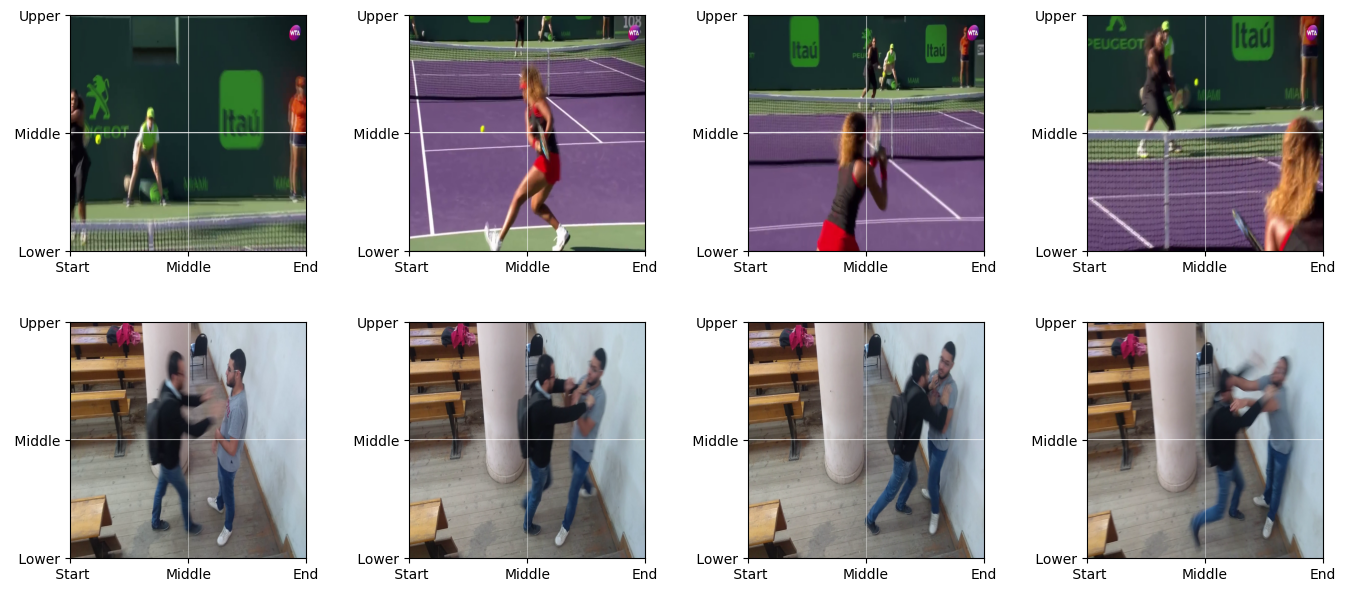

In [5]:
def extract_frames_for_visual(video_file, num_frames=4):
    cap = cv2.VideoCapture(video_file)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    frames = []
    step = max(1, total_frames // num_frames)

    # Initializing augmenters
    zoom_transform = iaa.Affine(scale=(1,1.5))
    brightness_transform = iaa.Multiply((0.8, 1.5))
    blur_transform = iaa.GaussianBlur(sigma=(0.5, 1.5))

    for i in range(num_frames):
        frame_index = i * step
        cap.set(cv2.CAP_PROP_POS_FRAMES, frame_index)
        ret, frame = cap.read()
        if ret:
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

            # Applying augmentation techniques - comment out these lines if you want to extract original version of images
            frame = brightness_transform(image=frame)
            frame = zoom_transform(image=frame)
            frame = blur_transform(image=frame)

            # Draw lines to show the center of the image
            center_x, center_y = frame.shape[1] // 2, frame.shape[0] // 2
            color = (255, 255, 255)
            thickness = 2
            frame = cv2.line(frame, (center_x, 0), (center_x, frame.shape[0] - 1), color, thickness)
            frame = cv2.line(frame, (0, center_y), (frame.shape[1] - 1, center_y), color, thickness)

            frames.append(frame)
    cap.release()
    return frames

def plot_frames(all_frames):
    fig, axs = plt.subplots(2, 4, figsize=(14, 6))

    for row in range(2):
        for col in range(4):
            ax = axs[row, col]
            img = all_frames[row][col]
            ax.imshow(img)
            ax.axis('on')

            # Set ticks on both axes
            ax.set_xticks([0, img.shape[1] // 2, img.shape[1] - 1])
            ax.set_yticks([0, img.shape[0] // 2, img.shape[0] - 1])

            # Update the labels
            ax.set_xticklabels([' Start', 'Middle', 'End'], fontsize=10)
            ax.set_yticklabels(['Upper', ' Middle', ' Lower'], fontsize=10)

            # Adjust subplot aspect ratio based on image dimensions
            ax.set_aspect(aspect=float(img.shape[1]) / float(img.shape[0]))

    # Padding and spacing settings
    plt.tight_layout(pad=1.0)
    plt.subplots_adjust(hspace=0.3, wspace=0.1)
    plt.show()

# Paths to selected two videos
video_paths = [
    f"{NonViolent}/NV_269.mp4",
    f"{Violent}/V_5.mp4"
]

# Extract frames from each video
all_video_frames = [extract_frames_for_visual(video) for video in video_paths]

# Plotting all frames in a 2x4 grid
plot_frames(all_video_frames)


# Feature Engineering

## Converting the video to sequence of frames

In [ ]:
def extract_frames(video_path):
    # Initialize an empty list to store the extracted frames
    frames = []

    # Read the video file
    video_reader = cv2.VideoCapture(video_path)

    # Get the total number of frames in the video
    total_frames = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))

    # Calculate the interval after which frames will be added to the list
    skip_frame_interval = max(int(total_frames / nframes), 1)

    # Iterate through the video frames
    for frame_index in range(nframes):
        # Set the current frame position of the video
        video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_index * skip_frame_interval)

        # Read the frame from the video
        success, image = video_reader.read()

        # Defining augmenters
        zoom_transform = iaa.Affine(scale=(1,1.5))
        brightness_transform = iaa.Multiply((0.8, 1.5))
        blur_transform = iaa.GaussianBlur(sigma=(0.5, 1.5))

        # Apply augmentation techniques
        augmented_image = brightness_transform(image=image)
        augmented_image = zoom_transform(image=augmented_image)
        augmented_image = blur_transform(image = augmented_image)

        # Resize the frame to fixed height and width
        resized_frame = cv2.resize(augmented_image, (HEIGHT, WIDTH))

        # Normalize the resized frame
        normalized_frame = resized_frame / 255

        # Append the normalized frame into the frames list
        frames.append(normalized_frame)


    video_reader.release()

    # Return the list of frames
    return frames


In [ ]:
def model_dataset():
    # Initialize lists to store features, labels, and video file paths
    features = []
    labels = []
    video_paths = []

    # total number of files to process
    total_files_to_process = 1600
    processed_files_count = 0

    # Iterate through all the classes
    for class_index, class_name in enumerate(CLASSES):
        # Print the current class being processed
        print(f'Extracting Data for Class: {class_name}')

        # Get the list of video files present in the specific class directory
        video_files = os.listdir(os.path.join(DATASET, class_name))

        # Iterate through the video files, limited to the first 250 files
        for video_file in video_files[200:]:
            # Get the complete video path
            video_path = os.path.join(DATASET, class_name, video_file)

            # Apply function to extract frames from the video file
            frames = extract_frames(video_path)

            # Check if the extracted frames match the specified sequence length
            # Ignore videos with frames less than the sequence length
            if len(frames) == nframes:
                # Append the data to their respective lists
                features.append(frames)
                labels.append(class_index)
                video_paths.append(video_path)

            # Update progress
            processed_files_count += 1
            if processed_files_count % 100 == 0:
              progress_percentage = (processed_files_count / total_files_to_process) * 100
              print(f'Progress: {progress_percentage:.2f}%')

    # Convert lists to numpy arrays
    features = np.asarray(features)
    labels = np.array(labels)

    # Return the extracted features, class labels, and video file paths
    return features, labels, video_paths


In [ ]:
features, labels, video_paths = model_dataset()

Extracting Data for Class: NonViolence
Progress: 6.25%
Progress: 12.50%
Progress: 18.75%
Progress: 25.00%
Progress: 31.25%
Progress: 37.50%
Progress: 43.75%
Progress: 50.00%
Extracting Data for Class: Violence
Progress: 56.25%
Progress: 62.50%
Progress: 68.75%
Progress: 75.00%
Progress: 81.25%
Progress: 87.50%
Progress: 93.75%
Progress: 100.00%


## Saving the processed data to Drive

In [ ]:
drive_base_path =f"{DATASET}/extracted_frames/full_dataset/"
features_file_path = os.path.join(drive_base_path, 'features.npy')
labels_file_path = os.path.join(drive_base_path, 'labels.npy')
video_paths_file_path = os.path.join(drive_base_path, 'video_paths.npy')


# Save the arrays to the specified file paths
np.save(features_file_path, features)
np.save(labels_file_path, labels)
np.save(video_paths_file_path, video_paths)

print("Features, labels, and video paths have been saved to Drive.")


(1600, 15, 100, 100, 3)
Features, labels, and video paths have been saved to Drive.
